<a href="https://colab.research.google.com/github/gopalkalpande/Practice-AI/blob/master/lstm_for_closing_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock value prediction from Open, High, Low

# Import module

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Input parameters 

In [0]:
stock_name = 'INFY'
seq_len = 22
rate = 0.4
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

# 1. Download data and normalize it
Data since 1950 to today

In [0]:
def get_stock_data(stock_name, normalize=True):
    start = datetime.datetime(2013, 1, 1)
    end = datetime.datetime(2018,12,31)
    df = web.DataReader(stock_name, "yahoo", start, end)
    df.drop(['Volume', 'Adj Close'], 1, inplace=True)
    
    if normalize:        
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

In [0]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2018,12,31)
df = web.DataReader(stock_name, "yahoo", start, end)
df.drop(['Volume', 'Adj Close'], 1, inplace=True)
df.head()

High      Low     Open    Close
Date                                          
2013-01-02  5.44500  5.32000  5.43625  5.35750
2013-01-03  5.47875  5.36375  5.38250  5.43375
2013-01-04  5.36750  5.29250  5.36750  5.33500
2013-01-07  5.41500  5.33500  5.33750  5.41125
2013-01-08  5.35000  5.30375  5.31125  5.31500

In [0]:
df = get_stock_data(stock_name, normalize=True)
#df = pd.read_csv('/content/drive/My Drive/data/lstm/nasdaq100_padding.csv')

In [0]:
df.head()

High       Low      Open     Close
Date                                              
2013-01-02  0.087642  0.080521  0.086870  0.079921
2013-01-03  0.093558  0.088242  0.077365  0.093278
2013-01-04  0.074058  0.075667  0.074713  0.075980
2013-01-07  0.082384  0.083168  0.069408  0.089337
2013-01-08  0.070990  0.077653  0.064766  0.072476

In [0]:
df.shape

(1510, 4)

# 2. Plot out the Normalized Adjusted close price

In [0]:
def plot_stock(df):
    df = get_stock_data(stock_name, normalize=True)
    print(df.head())
    plt.plot(df['Close'], color='red', label='Close')
    plt.legend(loc='best')
    plt.show()

                High       Low      Open     Close
Date                                              
2013-01-02  0.087642  0.080521  0.086870  0.079921
2013-01-03  0.093558  0.088242  0.077365  0.093278
2013-01-04  0.074058  0.075667  0.074713  0.075980
2013-01-07  0.082384  0.083168  0.069408  0.089337
2013-01-08  0.070990  0.077653  0.064766  0.072476


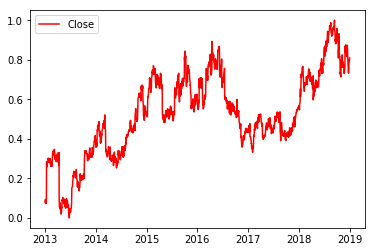

In [0]:
plot_stock(df)

In [0]:

rolmean = df.Close.rolling(12).mean()
rolstd = df.Close.rolling(12).std() 


In [0]:
rolmean1 = df.Close.rolling(5).mean()
rolstd1 = df.Close.rolling(5).std() 
df['moving_average'] = rolmean1
df['moving_variance'] = rolstd1

In [0]:
df1 = df
df1 = df1.drop(['High', 'High', 'Open'], axis = 1)

In [0]:
df1 = df1.drop(['Low'], axis = 1)
df1.head(15)

Close  moving_average  moving_variance
Date                                                 
2013-01-02  0.079921             NaN              NaN
2013-01-03  0.093278             NaN              NaN
2013-01-04  0.075980             NaN              NaN
2013-01-07  0.089337             NaN              NaN
2013-01-08  0.072476        0.082198         0.008833
2013-01-09  0.075980        0.081410         0.009253
2013-01-10  0.103788        0.083512         0.013041
2013-01-11  0.284870        0.125290         0.090058
2013-01-14  0.278520        0.163127         0.108938
2013-01-15  0.258156        0.200263         0.101720
2013-01-16  0.265382        0.238143         0.075841
2013-01-17  0.282899        0.273965         0.011652
2013-01-18  0.284651        0.273922         0.011601
2013-01-22  0.280272        0.274272         0.011799
2013-01-23  0.302387        0.283118         0.013194

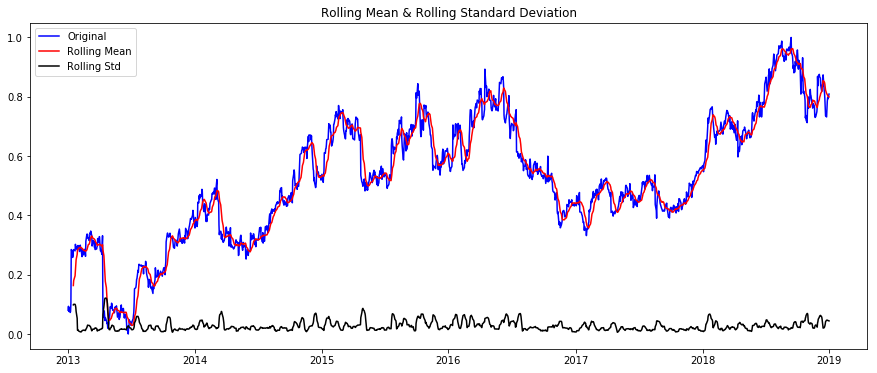

In [0]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
orig = plt.plot(df.Close, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show(block=False)

In [0]:
from statsmodels.tsa.stattools import adfuller

In [0]:
dftest = adfuller(df.Close, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   -2.467311
p-value                           0.123632
#Lags Used                        0.000000
Number of Observations Used    1509.000000
Critical Value (1%)              -3.434691
Critical Value (5%)              -2.863457
Critical Value (10%)             -2.567791
dtype: float64


# 3. Set last day Close as y

In [0]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [0]:
'''from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

def load_data_1(stock, split_point):
    amount_of_features = len(stock.columns)
    stock = np.array(stock)
    X = stock[:,:-1]
    y = stock[:,-1]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = split_point, shuffle = False)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  
    
    return [X_train, y_train, X_test, y_test]  '''

'from sklearn import model_selection\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.model_selection import TimeSeriesSplit\n\ndef load_data_1(stock, split_point):\n    amount_of_features = len(stock.columns)\n    stock = np.array(stock)\n    X = stock[:,:-1]\n    y = stock[:,-1]\n    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = split_point, shuffle = False)\n    \n    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))\n    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  \n    \n    return [X_train, y_train, X_test, y_test]  '

In [0]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# X_train, y_train, X_test, y_test = load_data_1(df, .25)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1338, 22, 4), (149, 22, 4), (1338,), (149,))

In [0]:
X_train.itemsize

8

In [0]:
# X_test.tail()

In [0]:


X_train.shape[0], X_train.shape[1], X_train.shape[2]

(1338, 22, 4)

In [0]:
# y_train.head()

# 4. Buidling neural network

In [0]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(rate, noise_shape=None, seed=None))
    
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(rate, noise_shape=None, seed=None))
        
    model.add(LSTM(neurons[2], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(rate, noise_shape=None, seed=None))
        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[4],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    # adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# 6. Model Execution

In [0]:
seq_len = 22
rate = 0.4
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 256, 128, 32, 1]
epochs = 300

model = build_model2(shape, neurons, rate)
# layers = [4, 22, 1]

W0623 16:05:27.598786 140245755078528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 16:05:27.643777 140245755078528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 16:05:27.652926 140245755078528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 16:05:27.903298 140245755078528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0623 16:05:27.911127 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 22, 256)           394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
__________

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 22, 256)           394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 256)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
__________

In [0]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)

Train on 1204 samples, validate on 134 samples
Epoch 1/300
1204/1204 [==============================] - 4s 3ms/step - loss: 0.2535 - acc: 8.3056e-04 - val_loss: 0.3609 - val_acc: 0.0000e+00
Epoch 2/300
1204/1204 [==============================] - 0s 303us/step - loss: 0.1939 - acc: 8.3056e-04 - val_loss: 0.1517 - val_acc: 0.0000e+00
Epoch 3/300
1204/1204 [==============================] - 0s 297us/step - loss: 0.0570 - acc: 8.3056e-04 - val_loss: 0.0124 - val_acc: 0.0000e+00
Epoch 4/300
1204/1204 [==============================] - 0s 300us/step - loss: 0.0495 - acc: 0.0000e+00 - val_loss: 0.0101 - val_acc: 0.0000e+00
Epoch 5/300
1204/1204 [==============================] - 0s 311us/step - loss: 0.0409 - acc: 0.0000e+00 - val_loss: 0.0426 - val_acc: 0.0000e+00
Epoch 6/300
1204/1204 [==============================] - 0s 324us/step - loss: 0.0373 - acc: 8.3056e-04 - val_loss: 0.0720 - val_acc: 0.0000e+00
Epoch 7/300
1204/1204 [==============================] - 0s 331us/step - loss: 0.0415

# 7. Result on training set and testing set

In [0]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [0]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00095 MSE (0.03 RMSE)
Test Score: 0.00434 MSE (0.07 RMSE)


(0.0009497975161777996, 0.0043373436654524115)

# 8. Prediction vs Real results

In [0]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [0]:
p = percentage_difference(model, X_test, y_test)

In [0]:
len(y_test)

149

# 9. Plot out prediction

In [0]:
def denormalize(stock_name, normalized_value):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    
    df = df['Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

In [0]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Close')
    plt2.show()
    return newp,newy_test

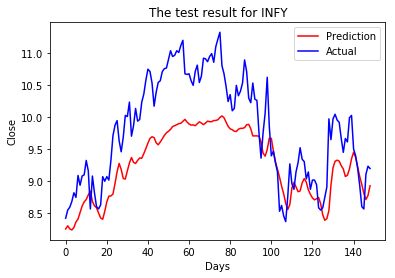

In [0]:
newp,newy_test = plot_result(stock_name, p, y_test)

In [0]:

my_pred = pd.DataFrame(columns=['pred', 'actual'])
my_pred.head()

Empty DataFrame
Columns: [pred, actual]
Index: []

In [0]:
my_pred['pred'] = newp.tolist()
my_pred['actual'] = newy_test.tolist()

In [0]:
my_pred.head()

pred               actual
0  [8.250595092773438]  [8.418510250096968]
1  [8.300057411193848]  [8.544661442008255]
2  [8.251545906066895]   [8.58971666674878]
3  [8.235519409179688]   [8.67982539754874]
4  [8.271662712097168]  [8.814987634408132]

In [0]:
my_pred.to_csv('LSTM_Stock_prediction_1.csv', sep=',', encoding='utf-8')

# 10. Save for consistency

In [0]:
model.save('LSTM_Stock_prediction-1.h5')

# Part 2. Fine tune model
# 11. Function to load data, train model and see score

In [0]:
stock_name = 'INFY'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 256, 128, 32, 1]
epochs = 300

In [0]:
def quick_measure(stock_name, seq_len, rate, shape, neurons, epochs):
    df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model2(shape, neurons, rate)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

# 12. Fine tune hyperparameter

12.1 Optimial Dropout value

In [0]:
dlist = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
neurons_LSTM = [32, 64, 128, 256, 512, 1024, 2048]
dropout_result = {}

for d in dlist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, rate, shape, neurons, epochs)
    dropout_result[rate] = testScore

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_31 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 22, 256)           394240    
_________________________________________________________________
dropout_32 (Dropout)         (None, 22, 256)           0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                4128      
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_34 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 22, 256)           394240    
_________________________________________________________________
dropout_35 (Dropout)         (None, 22, 256)           0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_36 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                4128      
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_37 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 22, 256)           394240    
_________________________________________________________________
dropout_38 (Dropout)         (None, 22, 256)           0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                4128      
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_40 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 22, 256)           394240    
_________________________________________________________________
dropout_41 (Dropout)         (None, 22, 256)           0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_42 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                4128      
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_43 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 22, 256)           394240    
_________________________________________________________________
dropout_44 (Dropout)         (None, 22, 256)           0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                4128      
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_46 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 22, 256)           394240    
_________________________________________________________________
dropout_47 (Dropout)         (None, 22, 256)           0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_48 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                4128      
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_49 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 22, 256)           394240    
_________________________________________________________________
dropout_50 (Dropout)         (None, 22, 256)           0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                4128      
__________

In [0]:
min_val = min(dropout_result.values())
min_val_key = [k for k, v in dropout_result.items() if v == min_val]
print (dropout_result)
print (min_val_key)

{0.4: 0.005058582065839495}
[0.4]


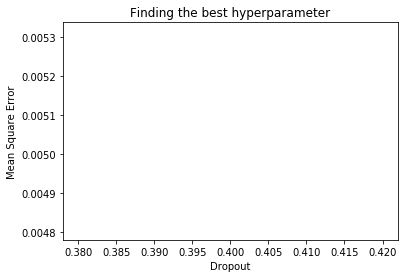

In [0]:
lists = sorted(dropout_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

12.2 Optimial epochs value

In [0]:
stock_name = 'INFY'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [128,256, 128, 32, 1]
epochslist = [10,20,30,40,50,60,70,80,90,100]

In [0]:
epochs_result = {}

for epochs in epochslist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, rate, shape, neurons, epochs)
    epochs_result[epochs] = testScore

In [0]:
lists = sorted(epochs_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.show()

12.3 Optimal number of neurons

In [0]:
stock_name = 'INFY'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
epochs = 90
dropout = 0.3
neuronlist1 = [32, 64, 128, 256, 512]
neuronlist2 = [16, 32, 64]
neurons_result = {}

for neuron_lstm in neuronlist1:
    neurons = [neuron_lstm, neuron_lstm]
    for activation in neuronlist2:
        neurons.append(activation)
        neurons.append(1)
        trainScore, testScore = quick_measure(stock_name, seq_len, rate, shape, neurons, epochs)
        neurons_result[str(neurons)] = testScore
        neurons = neurons[:2]    

In [0]:
lists = sorted(neurons_result.items())
x,y = zip(*lists)

plt.title('Finding the best hyperparameter')
plt.xlabel('neurons')
plt.ylabel('Mean Square Error')

plt.bar(range(len(lists)), y, align='center')
plt.xticks(range(len(lists)), x)
plt.xticks(rotation=90)

plt.show()

12.4 Optimial Dropout value

In [0]:
stock_name = 'INFY'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [512, 512, 64, 1]
epochs = 90
decaylist = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [0]:
def build_model3(layers, neurons, rate, decay):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(rate))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(rate))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [0]:
def quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay):
    df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model3(shape, neurons, rate, decay)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

In [0]:
decay_result = {}

for decay in decaylist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, rate, shape, neurons, epochs, decay)
    decay_result[decay] = testScore

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 22, 512)           1058816   
_________________________________________________________________
dropout_6 (Dropout)          (None, 22, 512)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 22, 512)           1058816   
_________________________________________________________________
dropout_8 (Dropout)          (None, 22, 512)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 22, 512)           1058816   
_________________________________________________________________
dropout_10 (Dropout)         (None, 22, 512)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 22, 512)           1058816   
_________________________________________________________________
dropout_12 (Dropout)         (None, 22, 512)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 22, 512)           1058816   
_________________________________________________________________
dropout_14 (Dropout)         (None, 22, 512)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 22, 512)           1058816   
_________________________________________________________________
dropout_16 (Dropout)         (None, 22, 512)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 22, 512)           1058816   
_________________________________________________________________
dropout_18 (Dropout)         (None, 22, 512)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 22, 512)           1058816   
_________________________________________________________________
dropout_20 (Dropout)         (None, 22, 512)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 22, 512)           1058816   
_________________________________________________________________
dropout_22 (Dropout)         (None, 22, 512)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


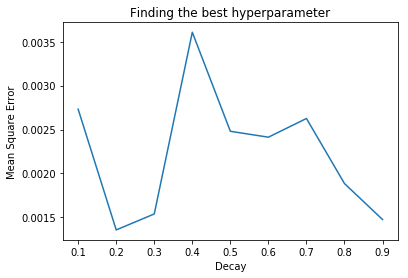

In [25]:
lists = sorted(decay_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Decay')
plt.ylabel('Mean Square Error')
plt.show()

In [0]:
stock_name = 'INFY'
neurons = [512, 512, 64, 1]
epochs = 90
rate = 0.3 #dropout
decay = 0.2

In [27]:
seq_len_list = [5, 10, 22, 60, 120, 180]

seq_len_result = {}

for seq_len in seq_len_list:
    shape = [4, seq_len, 1]
    
    trainScore, testScore = quick_measure(stock_name, seq_len, rate, shape, neurons, epochs, decay)
    seq_len_result[seq_len] = testScore

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 5, 512)            1058816   
_________________________________________________________________
dropout_24 (Dropout)         (None, 5, 512)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 10, 512)           1058816   
_________________________________________________________________
dropout_26 (Dropout)         (None, 10, 512)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 22, 512)           1058816   
_________________________________________________________________
dropout_28 (Dropout)         (None, 22, 512)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 60, 512)           1058816   
_________________________________________________________________
dropout_30 (Dropout)         (None, 60, 512)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 120, 512)          1058816   
_________________________________________________________________
dropout_32 (Dropout)         (None, 120, 512)          0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 180, 512)          1058816   
_________________________________________________________________
dropout_34 (Dropout)         (None, 180, 512)          0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_35 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


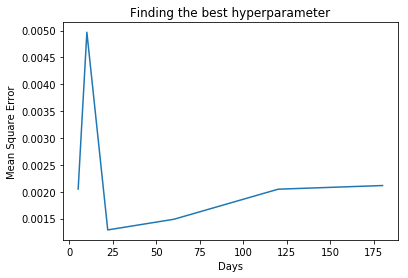

In [28]:
lists = sorted(seq_len_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Days')
plt.ylabel('Mean Square Error')
plt.show()

In [29]:
seq_len = 22
shape = [4, seq_len, 1]
    
trainScore, testScore = quick_measure(stock_name, seq_len, rate, shape, neurons, epochs, decay)
seq_len_result[seq_len] = testScore

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 22, 512)           1058816   
_________________________________________________________________
dropout_36 (Dropout)         (None, 22, 512)           0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


In [0]:
p = percentage_difference(model, X_test, y_test)

In [0]:
#p, y_test

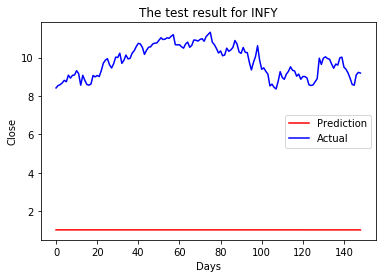

In [40]:
newp,newy_test = plot_result(stock_name, p, y_test)

In [0]:
my_pred = pd.DataFrame(columns=['pred', 'actual'])
my_pred.head()

my_pred['pred'] = newp.tolist()
my_pred['actual'] = newy_test.tolist()

my_pred.head()

my_pred.to_csv('LSTM_Stock_prediction_Close.csv', sep=',', encoding ='utf-8')

model.save('LSTM_Stock_prediction_Close.h5')

In [34]:
y_test.shape, my_pred['pred'].shape

((149,), (149,))

In [35]:
my_pred.head()

pred               actual
0  [1.0253956317901611]  [8.418510250096968]
1  [1.0253684520721436]  [8.544661442008255]
2  [1.0253374576568604]   [8.58971666674878]
3  [1.0252994298934937]   [8.67982539754874]
4  [1.0252554416656494]  [8.814987634408132]

In [0]:
#my_pred_1 = pd.DataFrame(columns=['pred', 'actual'])
#my_pred_1.head()

#my_pred_1['pred'] = newp
#my_pred_1['actual'] = newy_test

#my_pred.head()
print(newp, newy_test)

In [0]:
my_pred_data = np.concatenate((newy_test, newp), axis=1)
print(my_pred_data.view)

In [0]:
from statsmodels import robust
along_row = robust.mad(my_pred_data, axis=1)
along_column = robust.mad(my_pred_data, axis=0)

In [0]:
print(along_column)

In [0]:
print(along_row)

In [0]:
np.savetxt("LSTM_col_y-test_pred.csv", my_pred_data, delimiter=",")

In [0]:
from keras.models import model_from_json

In [0]:
def build_model3(layers, neurons, rate, decay):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(rate))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(rate))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [0]:

def quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay):
    df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model3(shape, neurons, rate, decay)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # serialize model to JSON
    model_json = model.to_json()
    with open("/content/drive/My Drive/abc/model.json", "w") as json_file:
        json_file.write(model_json)
    model.save('/content/drive/My Drive/abc/LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

In [0]:
stock_name = 'INFY'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [512, 512, 64, 1]
epochs = 90
rate = 0.3 #dropout
decay = 0.2


In [50]:
trainScore, testScore = quick_measure(stock_name, seq_len, rate, shape, neurons, epochs, decay)
seq_len_result[seq_len] = testScore

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 22, 512)           1058816   
_________________________________________________________________
dropout_40 (Dropout)         (None, 22, 512)           0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_41 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 65        
Total params: 3,190,913
Trainable params: 3,190,913
Non-trainable params: 0
_________________________________________________________________


In [0]:

# load json and create model
json_file = open('/content/drive/My Drive/abc/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/abc/LSTM_Stock_prediction-20170429.h5")

In [0]:
loaded_model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])


In [0]:
p = percentage_difference(loaded_model, X_test, y_test)

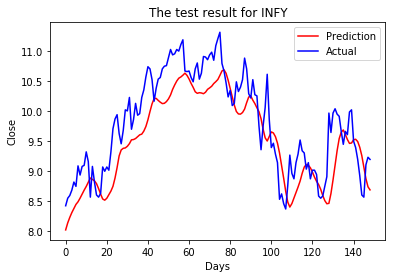

In [56]:
newp,newy_test = plot_result(stock_name, p, y_test)

In [58]:
model_score(loaded_model, X_train, y_train, X_test, y_test)

Train Score: 0.00128 MSE (0.04 RMSE)
Test Score: 0.00230 MSE (0.05 RMSE)


(0.0012843664479755166, 0.0023036579563963733)